In [97]:
import json, gzip, datetime, matplotlib.pyplot as plt, nltk, nltk.corpus, itertools
nltk.download('stopwords')
%matplotlib inline

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Charlie\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Posts within 24 hours and 10 miles radius

In [63]:
docsOR = [json.loads(line) for line in gzip.open('data/oregon-shooting.json.gz')]
docsPope = [json.loads(line) for line in gzip.open('data/pope-visit-dc.json.gz')]

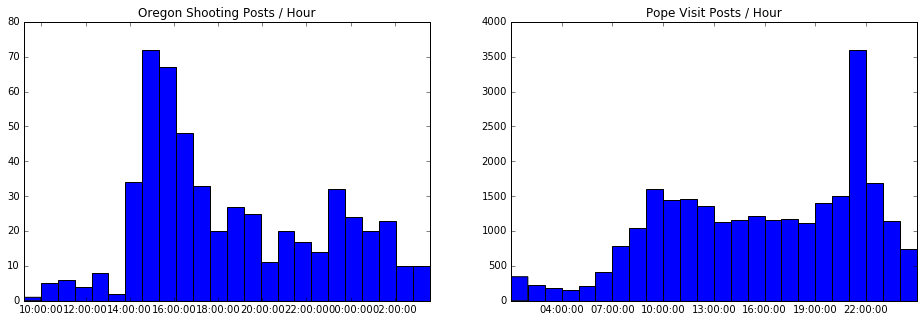

In [64]:
plt.figure(figsize=(16,5))
plt.subplot(121)
barsA = plt.hist([datetime.datetime.fromtimestamp(long(doc['timestamp_ms'])/1000.0) for doc in docsOR], bins=24)
titleA = plt.title('Oregon Shooting Posts / Hour')
plt.subplot(122)
barsB = plt.hist([datetime.datetime.fromtimestamp(long(doc['timestamp_ms'])/1000.0) for doc in docsPope], bins=24)
titleB = plt.title('Pope Visit Posts / Hour')

## A comparison of word freqencies in our training and test sets

In [92]:
docsTrain = [json.loads(line) for line in gzip.open('data/train.json.gz')]
stopwords = nltk.corpus.stopwords.words('english')
words = [w.lower() for w in itertools.chain(*[doc['text'].split() for doc in docsTrain]) if w.lower() not in stopwords]
fdist = nltk.FreqDist(words)
fdist.most_common(10)

[(u'#uccshooting', 26),
 (u"i'm", 24),
 (u'fox', 14),
 (u'producer', 12),
 (u'people', 12),
 (u'glad', 11),
 (u'please', 11),
 (u'everyone', 10),
 (u"can't", 10),
 (u'news.', 10)]

In [93]:
docsTest = [json.loads(line) for line in gzip.open('data/test.json.gz')]
words = [w.lower() for w in itertools.chain(*[doc['text'].split() for doc in docsTest]) if w.lower() not in stopwords]
fdist = nltk.FreqDist(words)
fdist.most_common(10)

[(u'#uccshooting', 33),
 (u"i'm", 30),
 (u'please', 26),
 (u'community', 20),
 (u'people', 19),
 (u'love', 17),
 (u'fox', 16),
 (u'go', 15),
 (u'producer', 15),
 (u'umpqua', 14)]

## A simple classifier based on word count

In [258]:
def relevance_features(doc):
    return {'word_count': len(doc['text'].split())}

# Load our training set and create a dictionary of the training posts
labeled_ids = json.load(open('data/train-set.json', 'r'))
docsTrainDict = {}
for doc in docsTrain: docsTrainDict[doc['id']] = doc

featuresets = [(relevance_features(docsTrainDict[doc_id]), relevance) for (doc_id, relevance) in labeled_ids]
train_set, test_set = featuresets[:100], featuresets[100:]
classifier = nltk.NaiveBayesClassifier.train(train_set)

classifier.show_most_informative_features(10)

Most Informative Features
              word_count = 22             relate : unrela =      3.3 : 1.0
              word_count = 15             unrela : relate =      3.0 : 1.0
              word_count = 6              unrela : relate =      2.6 : 1.0
              word_count = 17             relate : unrela =      2.6 : 1.0
              word_count = 9              relate : unrela =      2.4 : 1.0
              word_count = 18             relate : unrela =      2.4 : 1.0
              word_count = 23             relate : unrela =      2.4 : 1.0
              word_count = 4              unrela : relate =      2.1 : 1.0
              word_count = 12             relate : unrela =      1.8 : 1.0
              word_count = 14             unrela : relate =      1.6 : 1.0


In [259]:
[(x, classifier.classify({'word_count': x})) for x in xrange(1, 25)]

[(1, u'unrelated'),
 (2, u'unrelated'),
 (3, u'unrelated'),
 (4, u'unrelated'),
 (5, u'unrelated'),
 (6, u'unrelated'),
 (7, u'unrelated'),
 (8, u'unrelated'),
 (9, u'related'),
 (10, u'unrelated'),
 (11, u'unrelated'),
 (12, u'related'),
 (13, u'unrelated'),
 (14, u'unrelated'),
 (15, u'unrelated'),
 (16, u'unrelated'),
 (17, u'related'),
 (18, u'related'),
 (19, u'unrelated'),
 (20, u'unrelated'),
 (21, u'unrelated'),
 (22, u'related'),
 (23, u'related'),
 (24, u'related')]

In [260]:
nltk.classify.accuracy(classifier, test_set)

0.65

In [261]:
def relevance_features(doc):
    return {'word_count_gt8': len(doc['text'].split()) > 8}

featuresets = [(relevance_features(docsTrainDict[doc_id]), relevance) for (doc_id, relevance) in labeled_ids]
train_set, test_set = featuresets[:100], featuresets[100:]
classifier = nltk.NaiveBayesClassifier.train(train_set)

classifier.show_most_informative_features(10)

Most Informative Features
          word_count_gt8 = False          unrela : relate =      1.7 : 1.0
          word_count_gt8 = True           relate : unrela =      1.3 : 1.0


In [262]:
nltk.classify.accuracy(classifier, test_set)

0.85

## Stacking many classifiers

In [387]:
def relevance_features(doc):
    return {
        'word_count_gt8': len(doc['text'].split()) > 8,
        'has_hashtag': len(doc['entities']['hashtags']) > 0,
        'is_reply': bool(doc['in_reply_to_user_id']),
        'hour_posted': datetime.datetime.fromtimestamp(long(doc['timestamp_ms'])/1000.0).hour,
    }

featuresets = [(relevance_features(docsTrainDict[doc_id]), relevance) for (doc_id, relevance) in labeled_ids]
train_set, test_set = featuresets[:100], featuresets[100:]
classifier = nltk.NaiveBayesClassifier.train(train_set)

classifier.show_most_informative_features(5)

Most Informative Features
             has_hashtag = True           relate : unrela =      3.9 : 1.0
             hour_posted = 17             relate : unrela =      3.8 : 1.0
                is_reply = True           unrela : relate =      3.7 : 1.0
             hour_posted = 1              relate : unrela =      3.4 : 1.0
             hour_posted = 18             unrela : relate =      2.5 : 1.0


In [388]:
# Hour posted causes overfitting and reduces accuracy
nltk.classify.accuracy(classifier, test_set)

0.75

In [400]:
def relevance_features(doc):
    return {
        'word_count_gt8': len(doc['text'].split()) > 8,
        'has_hashtag': len(doc['entities']['hashtags']) > 0,
        'is_reply': bool(doc['in_reply_to_user_id']),
    }

featuresets = [(relevance_features(docsTrainDict[doc_id]), relevance) for (doc_id, relevance) in labeled_ids]
train_set, test_set = featuresets[:100], featuresets[100:]
classifier = nltk.NaiveBayesClassifier.train(train_set)

classifier.show_most_informative_features(5)

Most Informative Features
             has_hashtag = True           relate : unrela =      3.9 : 1.0
                is_reply = True           unrela : relate =      3.7 : 1.0
                is_reply = False          relate : unrela =      1.8 : 1.0
          word_count_gt8 = False          unrela : relate =      1.7 : 1.0
             has_hashtag = False          unrela : relate =      1.5 : 1.0


In [401]:
nltk.classify.accuracy(classifier, test_set)

0.91

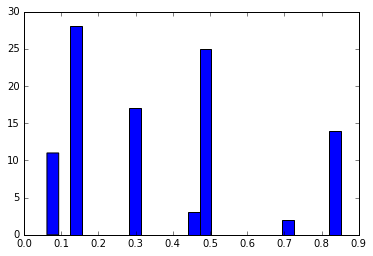

In [402]:
hist = plt.hist(sorted([classifier.prob_classify(x[0]).prob('related') for x in test_set]), bins=25)

In [403]:
probs = [(classifier.prob_classify(relevance_features(doc)).prob('related'), doc) for doc in docsTest]
probs.sort(key=lambda x: x[0], reverse=True)
[d['text'] for p,d in probs[:5]]

[u'Said one member of the #UCCShooting  community: "I don\'t want to know the names yet. I\'m not ready." http://t.co/VynqLDuGV4',
 u'From everybody in the roseburg area, please stop saying his name #stopsayinghisname',
 u'Community members say anger has been remarkably absent- so far - following #UCCShooting. That may change when IDs are released.',
 u'For some context: #ucc has a large nursing school, enrolls many veterans, Guard members. #UCCShooting',
 u'Hundreds gather for a vigil in Roseburg, Ore., after the #UCCschooting @Salem_Statesman http://t.co/Kz1STBHsFd']

In [404]:
import webbrowser
# Top 5 results
x = [webbrowser.open('https://twitter.com/statuses/'+d['id_str']) for p,d in probs[:5]]

In [394]:
# Bottom 5 results
x = [webbrowser.open('https://twitter.com/statuses/'+d['id_str']) for p,d in probs[-5:]]

## Apply our classifier to the Pope D.C. visit dataset

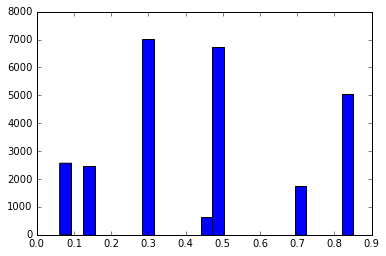

In [405]:
hist = plt.hist(sorted([classifier.prob_classify(relevance_features(doc)).prob('related') for doc in docsPope]), bins=25)

In [406]:
words = [w.lower() for w in itertools.chain(*[doc['text'].split() for doc in docsPope]) if w.lower() not in stopwords]
fdist = nltk.FreqDist(words)
fdist.most_common(10)

[(u'#popeindc', 1907),
 (u'@', 1491),
 (u"i'm", 1180),
 (u'pope', 1091),
 (u'like', 970),
 (u'&amp;', 816),
 (u'get', 752),
 (u"don't", 610),
 (u"it's", 609),
 (u'-', 601)]

In [407]:
probs = [(classifier.prob_classify(relevance_features(doc)).prob('related'), doc) for doc in docsPope]
probs.sort(key=lambda x: x[0], reverse=True)
[d['text'] for p,d in probs[:5]]

[u"I can't hear Austin call Steve a boy ever again please #BB17",
 u"Torian is a dumb ass .. they shouldn't win for this #Twinning",
 u'1. #Empire\n2. #BB17Finale\n3. #blackish\n4. #Rosewood\n5. #Nashville\n\n2015/9/23 21:36 CDT #trndnl http://t.co/IvleifByXY',
 u'Just like Congress @ the Nats game tonight #Mannywon http://t.co/3K9iqD72f8',
 u"My view from west front of Nat'l Basilica as @Pontifex arrived for Holy Mass! #PopeinUS #popeindc #semlife http://t.co/yZXZKsjzDX"]

In [408]:
[d['text'] for p,d in probs[:20] if 'pope' in d['text'].lower()]

[u"My view from west front of Nat'l Basilica as @Pontifex arrived for Holy Mass! #PopeinUS #popeindc #semlife http://t.co/yZXZKsjzDX",
 u'Waiting for Francis. Interfaith Vigil near Capitol til morning. #PopeInDC #followfrancis http://t.co/KcLQ6qpbyM',
 u'My wife was up close and personal!  #popefrancis #dc #bestfriends @ Busboys &amp; Poets. 5th and K St https://t.co/srKDstwySz',
 u'#ForwardMarch with #PopeInDC is enough to inspire any gym adventure. #MassOnTheElliptical']

In [411]:
# Top few results
x = [webbrowser.open('https://twitter.com/statuses/'+d['id_str']) for p,d in probs[:15] if 'pope' in d['text'].lower()]